# Training all models

The five features: "happiness", "sadness", "fear", "anger", "valence" are trained separately due to the regressor requirement.

## Part I Training

import modules and start spark session

In [1]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml.regression import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

appName = "Training multi features"
spark = SparkSession.builder.appName(appName).getOrCreate()

load and split dataset

In [3]:
dataset = spark.read.csv("../datasets/training_integrated_data.csv", header=True, inferSchema=True)
dividedData = dataset.randomSplit([0.7, 0.3], 24) 
trainingData = dividedData[0]
testingData = dividedData[1]

train models

In [4]:
features = ["happiness", "sadness", "fear", "anger", "valence"]
models = []

# define function to conbine features
feature_assembler = VectorAssembler(
    inputCols=["index", "cases", "newCases", "deaths", "positive", "negative"], 
    outputCol="features"
)
def Assemble(dataset, label: StringType):
    featured = feature_assembler.transform(dataset)
    return featured.select("features", col(chose_column).alias("label"))

# define machine learning algorithm
algorithm = LinearRegression(
    labelCol="label", 
    featuresCol="features", 
    maxIter=50
)

# define evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# loop to train five models
## this python script can be separated to five machines to train of course
## but the visulization will be in a separate notebook
for chose_column in features:

    trainingDataFinal = Assemble(trainingData, chose_column)
    testingDataFinal = Assemble(testingData, chose_column)

    model = algorithm.fit(trainingDataFinal)
    models.append(model)

    predict = model.transform(testingDataFinal)
    print (chose_column, " RMSE:", evaluator.evaluate(predict))

happiness  RMSE: 0.007360621991430297
sadness  RMSE: 0.005904285410723326
fear  RMSE: 0.009589857787426334
anger  RMSE: 0.006548169215609262
valence  RMSE: 0.0077668416613315755


## Part II Prediction

load data, build features

In [46]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

pred_dataset = spark.read.csv("../datasets/epidemic_pred.csv", header=True, inferSchema=True)
date = pred_dataset.select("date").toPandas()["date"].to_list()
dates_list = [datetime.strptime(d, '%Y-%m-%d').date() for d in date]
pred_dataset = pred_dataset.withColumn("index", pred_dataset["index"] + lit(580))
pred_data = feature_assembler.transform(pred_dataset).select("features")

predict

In [47]:
sentiments = []

for i in range(5):
    model = models[i]
    feature = features[i]

    predicted_sentiment = np.float64(model.transform(pred_data).select("prediction").collect())[:, 0]
    sentiments.append(predicted_sentiment)

visualizazion

C:\Users\regis\AppData\Local\Temp\ipykernel_11956\2232508991.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(dates_list, sentiments[i], marker='', linestyle='-')
C:\Users\regis\AppData\Local\Temp\ipykernel_11956\2232508991.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(dates_list, sentiments[i], marker='', linestyle='-')
C:\Users\regis\AppData\Local\Temp\ipykernel_11956\2232508991.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(dates_list, sentiments[i], marker='', linestyle='-')
C:\Users\regis\AppData\Local\Temp\ipykernel_11956\2232508991.py:7: UserWarning: marker is redundantly defined by the '

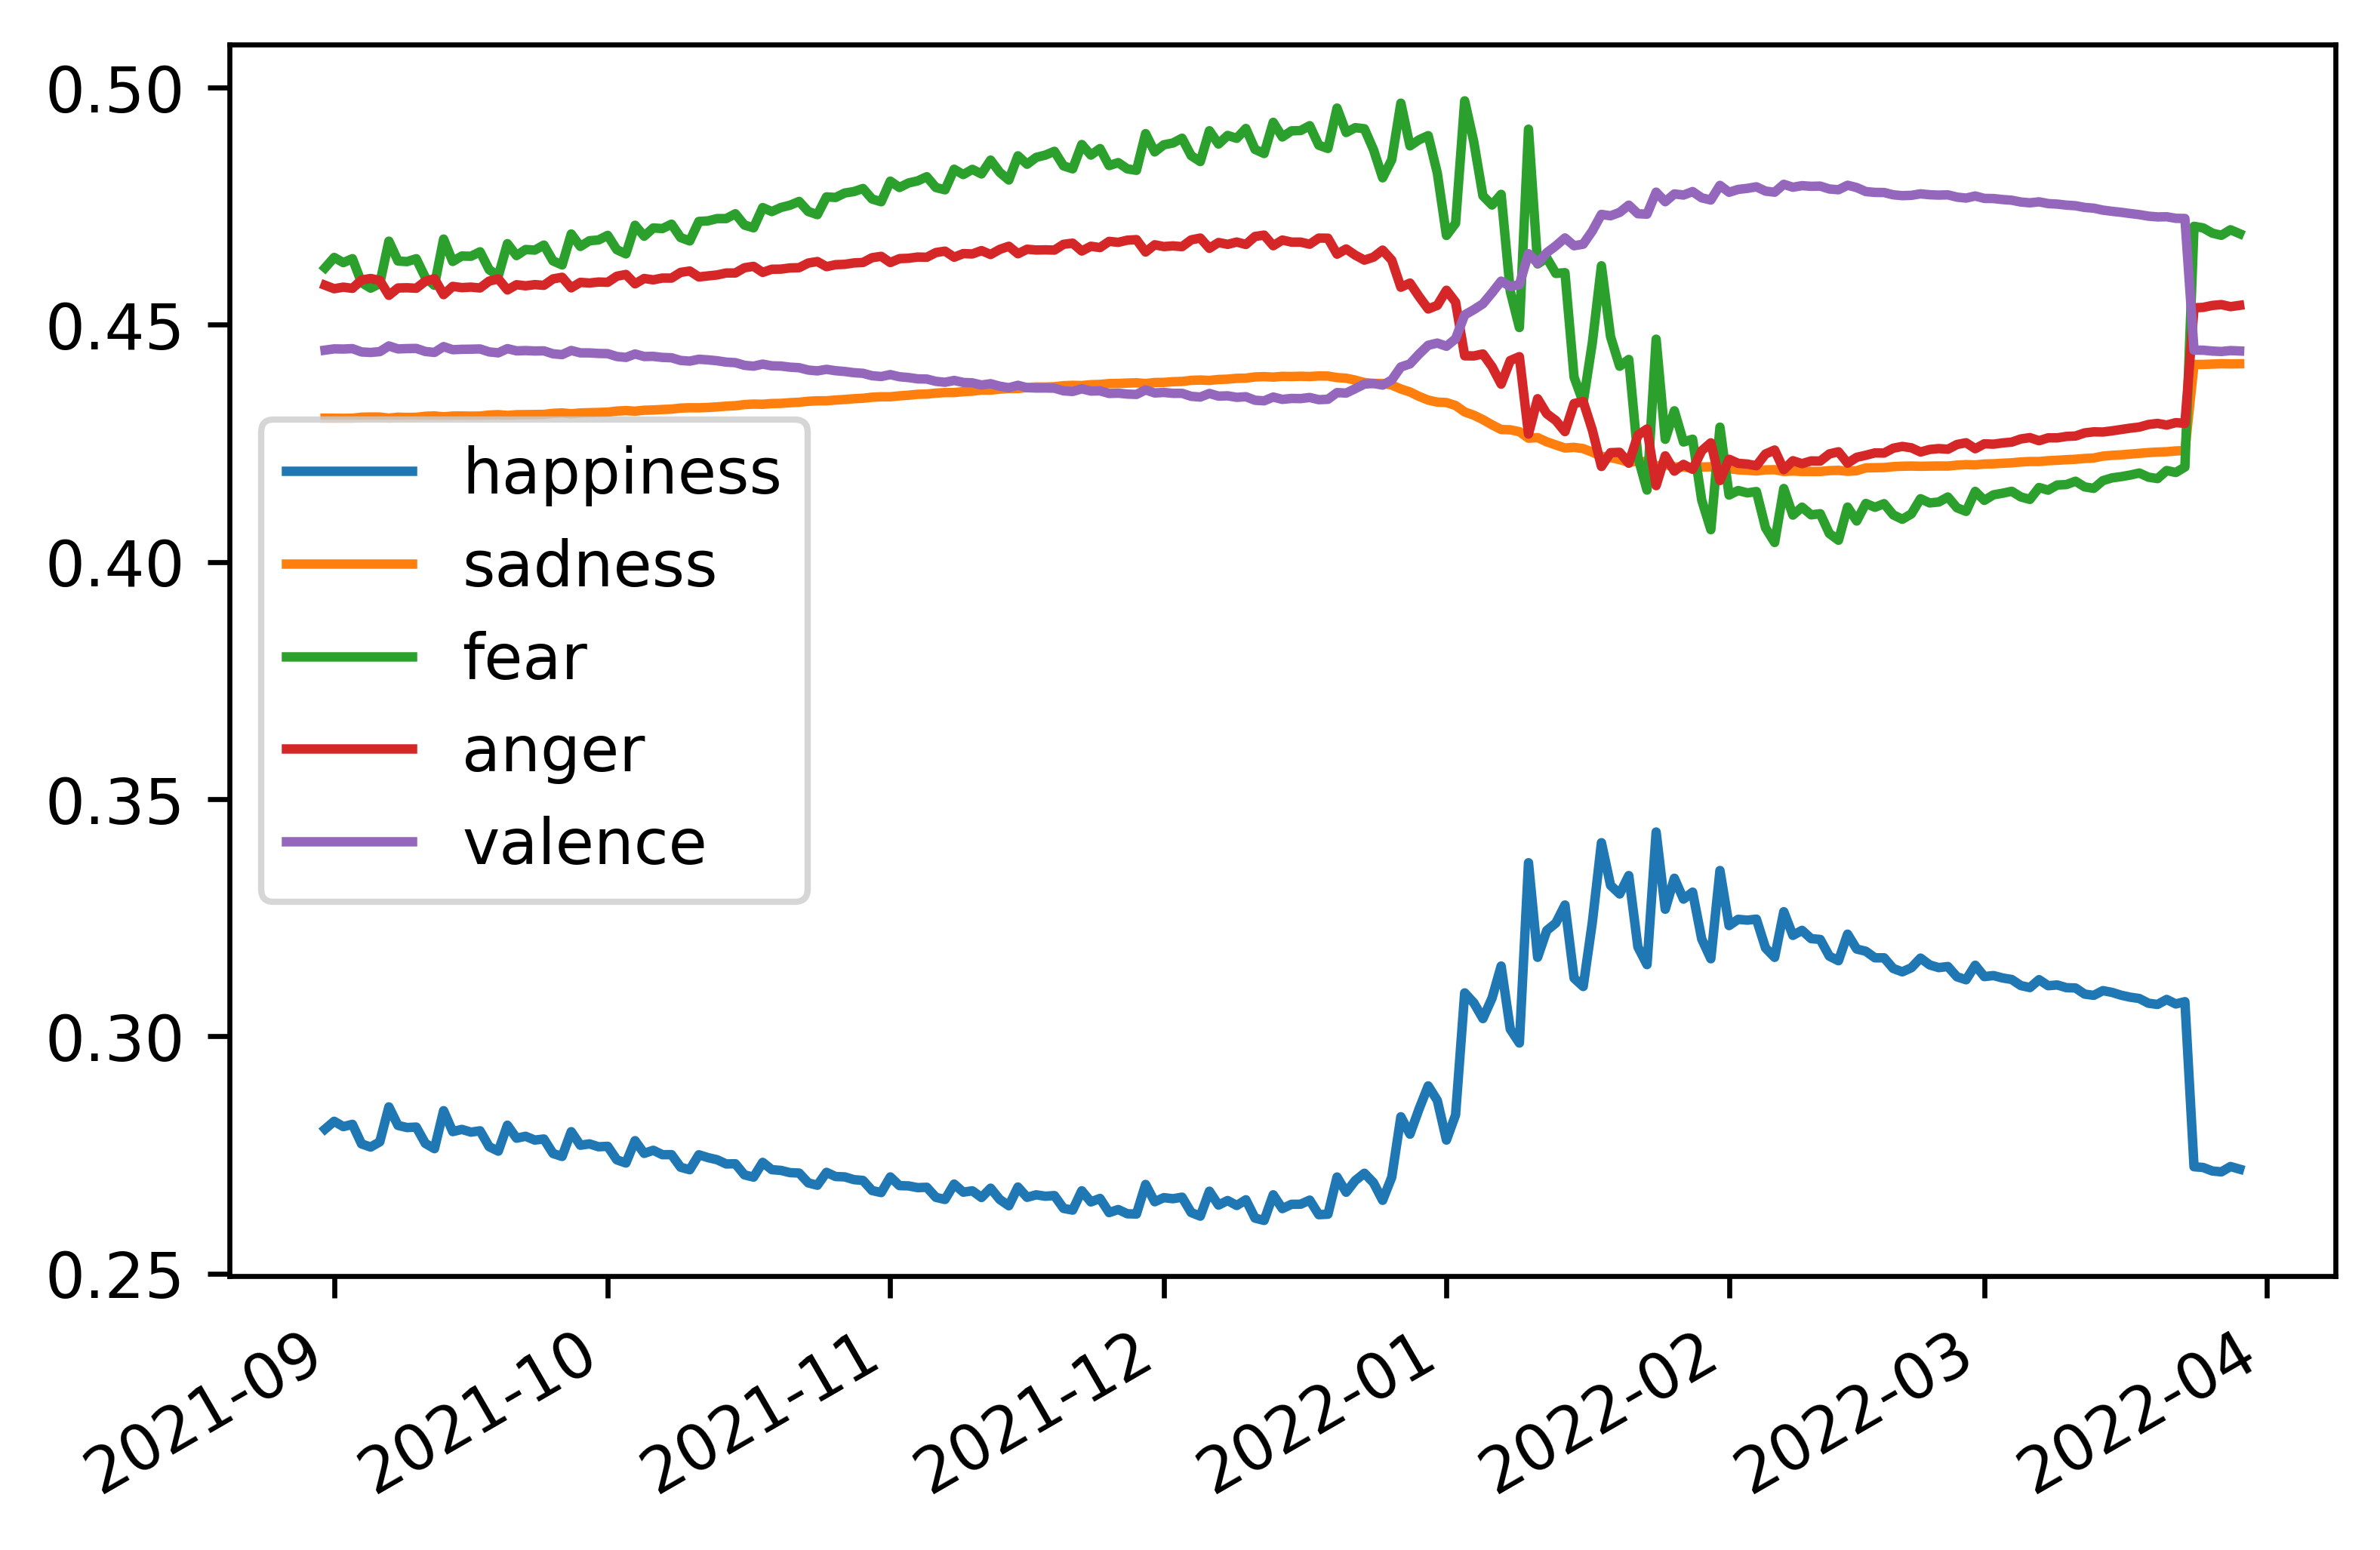

In [48]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 300

fig, ax = plt.subplots()

for i in range(5):
    ax.plot_date(dates_list, sentiments[i], marker='', linestyle='-')

ax.set_aspect('auto')
fig.autofmt_xdate()

plt.legend(features)
plt.show()